In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os 
from datetime import datetime
import math


In [2]:
basedirectory = os.getcwd()
os.chdir(r"C:\Users\ivann\OneDrive\Documents\~General Assembly Documents")


In [3]:
raw_data = pd.read_csv("DSI_kickstarterscrape_dataset.csv", encoding ="latin-1")

In [4]:
raw_data.head()
#two things you shoul always do, dataset.info() and dataset.describe()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,"Fri, 19 Aug 2011 19:28:17 -0000",7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,"Mon, 02 Aug 2010 03:59:00 -0000",5,"$1,$5,$10,$25,$50",6,0,47.18
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,"Fri, 08 Jun 2012 00:00:31 -0000",10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,"Sun, 08 Apr 2012 02:14:00 -0000",13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,"Wed, 01 Jun 2011 15:25:39 -0000",6,"$10,$25,$50,$100,$150,$250",2,0,30.00


In [5]:
display(raw_data.info())
display(raw_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45957 entries, 0 to 45956
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   project id         45957 non-null  int64  
 1   name               45957 non-null  object 
 2   url                45957 non-null  object 
 3   category           45957 non-null  object 
 4   subcategory        45957 non-null  object 
 5   location           44635 non-null  object 
 6   status             45957 non-null  object 
 7   goal               45957 non-null  float64
 8   pledged            45945 non-null  float64
 9   funded percentage  45957 non-null  float64
 10  backers            45957 non-null  int64  
 11  funded date        45957 non-null  object 
 12  levels             45957 non-null  int64  
 13  reward levels      45898 non-null  object 
 14  updates            45957 non-null  int64  
 15  comments           45957 non-null  int64  
 16  duration           459

None

,project id,goal,pledged,funded percentage,backers,levels,updates,comments,duration
count,4.595700e+04,4.595700e+04,4.594500e+04,45957.000000,45957.000000,45957.000000,45957.00000,45957.000000,45957.000000
mean,1.080800e+09,1.194271e+04,4.980750e+03,1.850129,69.973192,8.004939,4.08508,8.379529,39.995547
std,6.218057e+08,1.887583e+05,5.674162e+04,88.492706,688.628479,4.233907,6.43922,174.015737,17.414458
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,5.438962e+08,1.800000e+03,1.960000e+02,0.044000,5.000000,5.000000,0.00000,0.000000,30.000000
50%,1.078345e+09,4.000000e+03,1.310000e+03,1.000000,23.000000,7.000000,2.00000,0.000000,32.000000
75%,1.621596e+09,9.862000e+03,4.165000e+03,1.115640,59.000000,10.000000,6.00000,3.000000,48.390000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.00000,19311.000000,91.960000


In [6]:
#Let's update the data types on our raw data
data_updated_dtype = raw_data

In [7]:
#changing the project id from an integer to a string
data_updated_dtype['project id'] = data_updated_dtype['project id'].astype('string')


#let's put the day of the week into it's own column
data_updated_dtype[['Day of Week','funded date']] = data_updated_dtype['funded date'].str.split(',',n=1,expand=True)
#let's remove the annoying zeros at the end of the each entry
data_updated_dtype['funded date']= data_updated_dtype['funded date'].str.rstrip('-0000')
data_updated_dtype['Funded Date'] = pd.to_datetime(data_updated_dtype['funded date']).dt.date
data_updated_dtype['Funded Time'] = pd.to_datetime(data_updated_dtype['funded date']).dt.time
data_updated_dtype.head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration,Day of Week,Funded Date,Funded Time
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,19 Aug 2011 19:28:17,7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00,Fri,2011-08-19,19:28:17
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,02 Aug 2010 03:59:00,5,"$1,$5,$10,$25,$50",6,0,47.18,Mon,2010-08-02,03:59:00
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,08 Jun 2012 00:00:31,10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00,Fri,2012-06-08,00:00:31
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,08 Apr 2012 02:14:00,13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22,Sun,2012-04-08,02:14:00
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,01 Jun 2011 15:25:39,6,"$10,$25,$50,$100,$150,$250",2,0,30.00,Wed,2011-06-01,15:25:39


In [8]:
data_updated_dtype.describe()

,goal,pledged,funded percentage,backers,levels,updates,comments,duration
count,4.595700e+04,4.594500e+04,45957.000000,45957.000000,45957.000000,45957.00000,45957.000000,45957.000000
mean,1.194271e+04,4.980750e+03,1.850129,69.973192,8.004939,4.08508,8.379529,39.995547
std,1.887583e+05,5.674162e+04,88.492706,688.628479,4.233907,6.43922,174.015737,17.414458
min,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,1.800000e+03,1.960000e+02,0.044000,5.000000,5.000000,0.00000,0.000000,30.000000
50%,4.000000e+03,1.310000e+03,1.000000,23.000000,7.000000,2.00000,0.000000,32.000000
75%,9.862000e+03,4.165000e+03,1.115640,59.000000,10.000000,6.00000,3.000000,48.390000
max,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.00000,19311.000000,91.960000


In [9]:
#Now let's drop the original date time column
data_updated_dtype.drop(columns = ['funded date'], inplace = True)
data_updated_dtype.head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,reward levels,updates,comments,duration,Day of Week,Funded Date,Funded Time
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00,Fri,2011-08-19,19:28:17
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,5,"$1,$5,$10,$25,$50",6,0,47.18,Mon,2010-08-02,03:59:00
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00,Fri,2012-06-08,00:00:31
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22,Sun,2012-04-08,02:14:00
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,"$10,$25,$50,$100,$150,$250",2,0,30.00,Wed,2011-06-01,15:25:39


In [10]:
data_updated_dtype.head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,reward levels,updates,comments,duration,Day of Week,Funded Date,Funded Time
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00,Fri,2011-08-19,19:28:17
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,5,"$1,$5,$10,$25,$50",6,0,47.18,Mon,2010-08-02,03:59:00
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00,Fri,2012-06-08,00:00:31
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22,Sun,2012-04-08,02:14:00
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,"$10,$25,$50,$100,$150,$250",2,0,30.00,Wed,2011-06-01,15:25:39


In [11]:
#Let's check to see what type of data we have
data_updated_dtype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45957 entries, 0 to 45956
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   project id         45957 non-null  string 
 1   name               45957 non-null  object 
 2   url                45957 non-null  object 
 3   category           45957 non-null  object 
 4   subcategory        45957 non-null  object 
 5   location           44635 non-null  object 
 6   status             45957 non-null  object 
 7   goal               45957 non-null  float64
 8   pledged            45945 non-null  float64
 9   funded percentage  45957 non-null  float64
 10  backers            45957 non-null  int64  
 11  levels             45957 non-null  int64  
 12  reward levels      45898 non-null  object 
 13  updates            45957 non-null  int64  
 14  comments           45957 non-null  int64  
 15  duration           45957 non-null  float64
 16  Day of Week        459

In [12]:
data_updated_dtype.isna().any() #let's check for missing values in our updated dtype data set
#Expected output: 
# project id           False
# name                 False
# url                  False
# category             False
# subcategory          False
# location              True
# status               False
# goal                 False
# pledged               True
# funded percentage    False
# backers              False
# levels               False
# reward levels         True
# updates              False
# comments             False
# duration             False
# Day of Week          False
# Funded Date          False
# Funded Time          False
# dtype: bool

project id           False
name                 False
url                  False
category             False
subcategory          False
location              True
status               False
goal                 False
pledged               True
funded percentage    False
backers              False
levels               False
reward levels         True
updates              False
comments             False
duration             False
Day of Week          False
Funded Date          False
Funded Time          False
dtype: bool

In [13]:
#rename two word columns to be correct
data_updated_dtype["reward_levels"]=data_updated_dtype['reward levels']


In [14]:
#remove old reward levels column
data_updated_dtype.drop(columns=['reward levels'],inplace=True, axis=1)
data_updated_dtype.head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,7,10,2,30.00,Fri,2011-08-19,19:28:17,"$25,$50,$100,$250,$500,$1,000,$2,500"
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,5,6,0,47.18,Mon,2010-08-02,03:59:00,"$1,$5,$10,$25,$50"
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,10,1,0,28.00,Fri,2012-06-08,00:00:31,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001"
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,13,4,0,32.22,Sun,2012-04-08,02:14:00,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500..."
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,2,0,30.00,Wed,2011-06-01,15:25:39,"$10,$25,$50,$100,$150,$250"


In [15]:
#calling the number of null values in a specific column
pledged_null = data_updated_dtype.isnull().pledged.sum()
location_null = data_updated_dtype.isnull().location.sum()
reward_null = data_updated_dtype.isnull().reward_levels.sum()
print("null location count", location_null)
print("pledged null", pledged_null)  
print ("reward levels null", reward_null)

null location count 1322
pledged null 12
reward levels null 59


In [16]:
#Let's drop any rows that are missing locations, since we have no way to determine what the Location should be from the data we have.
data_updated_dtype.dropna(subset=['location'],inplace=True)

#let's double check that we removed all the null values
location_null = data_updated_dtype.isnull().location.sum()
print("null location count", location_null)

null location count 0


In [17]:
#let's drop the rows missing reward levels since we have no way to calculate this as well.
data_updated_dtype.dropna(subset=['reward_levels'],inplace=True)

#let's double check that we removed all the null values
reward_null = data_updated_dtype.isnull().reward_levels.sum()
print ("reward levels null", reward_null)

reward levels null 0


In [18]:
#We will now attempt to update the null pldeged values using Goal amount and funded percentage
#call all rows that do not contain a pledged amount
#Let's calculate a new column called "Calculted_Pledged" and compare that with the reported pldege amounts to see if they are 
#the same.
data_updated_dtype['Calculated_Pledged']=round(data_updated_dtype['goal']*(data_updated_dtype['funded percentage']),0)
data_updated_dtype['pledgedMatch?'] = np.where(data_updated_dtype['pledged'] == data_updated_dtype['Calculated_Pledged'], 'True', 'False')  
#create new column in df1 to check if pledged amounts  match

data_updated_dtype.sample(100)


,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,...,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels,Calculated_Pledged,pledgedMatch?
8209,389109237,The Human Revolution,http://www.kickstarter.com/projects/thehumanre...,Music,Music,"Mendocino, CA",successful,25000.0,25204.0,1.008173,...,12,5,3,30.00,Fri,2011-09-23,02:36:37,"$1,$15,$30,$35,$50,$100,$300,$800,$1,000,$2,00...",25204.0,True
32402,1523951366,Twaggies,http://www.kickstarter.com/projects/438979135/...,Comics,Comics,"Los Angeles, CA",failed,8000.0,935.0,0.116875,...,12,0,0,31.38,Tue,2010-10-19,03:59:00,"$1,$5,$10,$15,$20,$30,$50,$75,$125,$175,$500,$...",935.0,True
25695,1209679164,Kishi Bashi's making a debut album!!,http://www.kickstarter.com/projects/kishibashi...,Music,Indie Rock,"Norfolk, VA",successful,12000.0,20357.0,1.696424,...,12,19,92,23.91,Wed,2011-12-21,20:10:00,"$3,$15,$25,$35,$40,$50,$100,$250,$250,$500,$1,...",20357.0,True
23647,1110318153,Sol Driven Train's new album: Underdog,http://www.kickstarter.com/projects/147766955/...,Music,Rock,"Charleston, SC",successful,11000.0,12223.0,1.111182,...,18,6,13,55.21,Thu,2012-03-01,04:59:00,"$5,$10,$15,$25,$30,$50,$75,$100,$200,$300,$375...",12223.0,True
2417,113884926,The Wednesday Nights,http://www.kickstarter.com/projects/thewednesd...,Music,Music,"Maysville, KY",successful,1100.0,1250.0,1.136364,...,2,0,2,43.68,Wed,2011-11-23,10:00:00,"$1,$1,000",1250.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,50320503,La Pocha Nostra's conceptual live art credit u...,http://www.kickstarter.com/projects/20707272/l...,Art,Performance Art,"San Francisco, CA",successful,10000.0,10560.0,1.056000,...,8,7,4,49.51,Sat,2011-12-17,08:00:00,"$15,$20,$25,$50,$100,$500,$1,000,$3,000",10560.0,True
18945,892603062,&quot;Undocumented&quot; a play about undocume...,http://www.kickstarter.com/projects/katchua/un...,Theater,Theater,"New York, NY",successful,2000.0,2000.0,1.000000,...,6,2,0,60.00,Wed,2011-08-17,15:46:29,"$1,$20,$50,$130,$500,$1,000",2000.0,True
33704,1585523461,ISH Records 1st Full Album - Pineapple Tuesday,http://www.kickstarter.com/projects/musishan/i...,Music,Pop,"Chicago, IL",live,5000.0,200.0,0.040000,...,7,0,0,30.00,Sun,2012-06-24,06:19:06,"$1,$5,$20,$50,$100,$200,$500",200.0,True
7672,363147314,Sky Parades,http://www.kickstarter.com/projects/390106847/...,Publishing,Children's Book,"Paducah, KY",failed,1800.0,75.0,0.041667,...,2,0,0,30.00,Thu,2012-05-03,20:31:19,"$25,$200",75.0,True


In [19]:
#Let's add in the pldged amount where appropiate in our dataset
nullpledged_df = data_updated_dtype[data_updated_dtype.isnull().pledged]
nullpledged_df.head(20) #there should only be 12 rows in the pledged null data frame
# data_updated_dtype['pledged']=round(nullpledged_df['goal']*(nullpledged_df['funded percentage']),0)
# pledged_null = data_updated_dtype.isnull().pledged.sum()
# print("pledged null", pledged_null)  



,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,...,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels,Calculated_Pledged,pledgedMatch?
1187,55442017,Xenonauts,http://www.kickstarter.com/projects/69341191/x...,Games,Video Games,"London, United Kingdom",live,50000.0,NaN,2.219487,...,17,8,562,33.00,Sun,2012-06-10,23:19:04,"$20,$30,$50,$50,$50,$60,$75,$85,$100,$100,$125...",110974.0,False
4502,213683990,Twokinds Book Printing Drive,http://www.kickstarter.com/projects/twokinds/t...,Comics,Comics,"Cincinnati, OH",live,25000.0,NaN,6.303783,...,34,6,1133,31.24,Sat,2012-06-09,20:00:00,"$10,$12,$15,$20,$20,$20,$20,$25,$25,$35,$35,$4...",157595.0,False
13381,636029584,HICKIES - TURN YOUR KICKS INTO SLIP-ONS,http://www.kickstarter.com/projects/hickies/hi...,Design,Product Design,"Brooklyn, NY",live,25000.0,NaN,4.907843,...,9,6,119,45.00,Thu,2012-06-14,15:44:14,"$16,$30,$45,$59,$75,$90,$115,$300,$500",122696.0,False
13802,656206605,Genie - Motion control time lapse device,http://www.kickstarter.com/projects/syrp/genie...,Design,Product Design,"Queenstown, New Zealand",live,150000.0,NaN,2.999618,...,13,10,89,60.00,Tue,2012-06-26,06:29:41,"$1,$15,$30,$50,$100,$590,$690,$750,$790,$3,000...",449943.0,False
25239,1184761342,B9Creator - A High Resolution 3D Printer,http://www.kickstarter.com/projects/b9creation...,Technology,Open Hardware,"Deadwood, SD",live,50000.0,NaN,4.761380,...,11,12,100,33.07,Tue,2012-06-12,07:00:00,"$5,$25,$59,$99,$132,$183,$216,$2,375,$2,675,$3...",238069.0,False
29412,1382865280,Phil Tippett's &quot;MAD GOD&quot;,http://www.kickstarter.com/projects/madgod/phi...,Film &amp; Video,Animation,"Berkeley, CA",live,40000.0,NaN,2.532484,...,10,3,59,30.00,Sat,2012-06-16,22:36:31,"$10,$25,$55,$75,$100,$115,$300,$1,800,$3,600,$...",101299.0,False
31164,1467412732,gTar: The First Guitar That Anybody Can Play,http://www.kickstarter.com/projects/incident/g...,Technology,Technology,"Santa Clara, CA",live,100000.0,NaN,2.846420,...,11,4,44,35.00,Mon,2012-06-25,17:26:04,"$1,$25,$350,$399,$450,$499,$599,$699,$799,$999...",284642.0,False
34274,1612550316,Space Command,http://www.kickstarter.com/projects/58936338/s...,Film &amp; Video,Film &amp; Video,"Studio City, CA",live,75000.0,NaN,1.796187,...,22,24,279,60.00,Sun,2012-07-15,03:59:00,"$5,$8,$12,$17,$27,$37,$50,$67,$107,$257,$357,$...",134714.0,False
35032,1648656751,BronyCon: The Documentary,http://www.kickstarter.com/projects/257527888/...,Film &amp; Video,Documentary,"Los Angeles, CA",live,60000.0,NaN,3.148185,...,15,5,525,26.97,Sun,2012-06-10,18:59:00,"$10,$10,$30,$50,$75,$100,$150,$250,$500,$500,$...",188891.0,False
40759,1911111579,Two Guys SpaceVenture - by the creators of Spa...,http://www.kickstarter.com/projects/spaceventu...,Games,Video Games,"Eugene, OR",live,500000.0,NaN,0.583738,...,33,30,6895,35.00,Tue,2012-06-12,17:27:38,"$15,$30,$31,$45,$50,$60,$75,$100,$100,$101,$11...",291869.0,False


In [20]:
#Let's attempt to fill in the values for this temporary data frame
#the following code snippet was me testing how to use the np.where function, which essentialy acts like an if-then function.
#The function worked the way that I hoped it would
# nullpledged_df['pledged'] = np.where(nullpledged_df['pledged'].isnull(),round(nullpledged_df['goal']*(nullpledged_df['funded percentage']),0),nullpledged_df['pledged'])
# nullpledged_df.head(12)


In [21]:
#Use the numpy "where" function to replace NAN values in the data set with by calculating pledged amount from fundraising goal * pledged percentage.
data_updated_dtype['pledged'] = np.where(data_updated_dtype['pledged'].isnull(),round(data_updated_dtype['goal']*(data_updated_dtype['funded percentage']),0),data_updated_dtype['pledged'])
pledged_null = data_updated_dtype.isnull().pledged.sum()
#the expected output is 0. 
print("pledged null", pledged_null) 

pledged null 0


In [22]:
#create a new dataset to be used for further data cleaning
#We need to drop the extra columns we created, i.e. pledgedmatch? and calculated pledge
data_updated_dtype.drop(columns= ['Calculated_Pledged','pledgedMatch?'], inplace=True)
no_nulls_data= data_updated_dtype
no_nulls_data.head()



,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,7,10,2,30.00,Fri,2011-08-19,19:28:17,"$25,$50,$100,$250,$500,$1,000,$2,500"
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,5,6,0,47.18,Mon,2010-08-02,03:59:00,"$1,$5,$10,$25,$50"
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,10,1,0,28.00,Fri,2012-06-08,00:00:31,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001"
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,13,4,0,32.22,Sun,2012-04-08,02:14:00,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500..."
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,2,0,30.00,Wed,2011-06-01,15:25:39,"$10,$25,$50,$100,$150,$250"


In [23]:
#Next Step: Let's make sure all categories are unique and consistent
print(no_nulls_data.category.unique())
print(no_nulls_data.groupby(['category'])['category'].count())
#From our output, we see that Film & Video is written two ways, Film & Video + Film &amp; Video
#The total expected amount of listings that fall in the Film & video category is 13,082
#Expected output
# category
    # Art                  3872
    # Comics               1034
    # Dance                 744
    # Design               1738
    # Fashion              1117
    # Film & Video          482
    # Film &amp; Video    12600
    # Food                 1411
    # Games                1689
    # Music               10671
    # Photography          1424
    # Publishing           4585
    # Technology            774
    # Theater              2451

['Film & Video' 'Games' 'Fashion' 'Music' 'Art' 'Dance' 'Publishing'
 'Theater' 'Comics' 'Technology' 'Design' 'Photography' 'Food'
 'Film &amp; Video']
category
Art                  3872
Comics               1034
Dance                 744
Design               1738
Fashion              1117
Film & Video          482
Film &amp; Video    12600
Food                 1411
Games                1689
Music               10671
Photography          1424
Publishing           4585
Technology            774
Theater              2451
Name: category, dtype: int64


In [24]:
#Relace all instances of Film &amp; Video with Film & Video
no_nulls_data['category'] = np.where(no_nulls_data['category'] =='Film &amp; Video','Film & Video',no_nulls_data['category'])
print(no_nulls_data.groupby(['category'])['category'])


In [25]:
#let's identify the unique values of our subcategories
# print(no_nulls_data.subcategory.unique())
print(no_nulls_data.groupby(['subcategory'])['subcategory'].count())
# print(no_nulls_data.loc[no_nulls_data['subcategory'] == 'Board & Card Games'].count())


subcategory
Animation                  407
Art                       1037
Art Book                   333
Board & Card Games         110
Board &amp; Card Games     432
Children's Book            640
Classical Music            470
Comics                    1034
Conceptual Art             168
Country & Folk             249
Country &amp; Folk         777
Crafts                     247
Dance                      744
Design                     281
Digital Art                139
Documentary               3798
Electronic Music           298
Fashion                   1117
Fiction                   1057
Film &amp; Video          2432
Food                      1411
Games                      267
Graphic Design             171
Hip-Hop                    467
Illustration               195
Indie Rock                1880
Jazz                       431
Journalism                 381
Mixed Media                443
Music                     3187
Narrative Film            1510
Nonfiction                1

In [26]:
#Let's redefine Board &amp; Card Games,  Country &amp; Folk  ,  Film &amp; Video
no_nulls_data['subcategory'] = np.where(no_nulls_data['subcategory'] =='Film &amp; Video','Film & Video',no_nulls_data['subcategory'])
no_nulls_data['subcategory'] = np.where(no_nulls_data['subcategory'] =='Country &amp; Folk','Country & Folk',no_nulls_data['subcategory'])
no_nulls_data['subcategory'] = np.where(no_nulls_data['subcategory'] =='Board &amp; Card Games','Board & Card Games',no_nulls_data['subcategory'])

# for item  in no_nulls_data['subcategory']:
#     if (item == 'Film &amp; Video'):
#         no_nulls_data['subcategory'][item]= ('Film & Video')
#     else:
#         item = item
    
# no_nulls_data.shape
#In order to iterate over an index I need to reindex my code.
no_nulls_data.reset_index(drop=True, inplace= True)
no_nulls_data.head(20)
# print(no_nulls_data['subcategory'][0]);
# print(no_nulls_data['subcategory'][11]);
# i = 0;
# for i in range(len(no_nulls_data['subcategory'])):
# #     print(no_nulls_data['category'][i])
#     if no_nulls_data['subcategory'][i] == 'Film &amp; Video':
#         no_nulls_data['subcategory'][i] ="Film & Video"
#     elif no_nulls_data['subcategory'][i] == 'Board &amp; Card Games':
#         no_nulls_data['subcategory'][i] = "Board & Card Games"
#     elif no_nulls_data['subcategory'][i] == 'Country &amp; Folk':
#         no_nulls_data['subcategory'][i] ="Country & Folk"
# no_nulls_data.column = df.column.apply(<urstuff>)
    
        
        
#     if no_nulls_data['subcategory'][i] == 'Film &amp; Video':
#         no_nulls_data['subcategory'][i] = "Film & video"
#     else:
#         no_nulls_data['subcategory'][i] = no_nulls_data['subcategory'][i]
# no_nulls_data.head(20)
#Print statement to make sure everything was renamed properly
#print(no_nulls_data.subcategory.unique())
no_nulls_data.head()




,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,7,10,2,30.00,Fri,2011-08-19,19:28:17,"$25,$50,$100,$250,$500,$1,000,$2,500"
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,5,6,0,47.18,Mon,2010-08-02,03:59:00,"$1,$5,$10,$25,$50"
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,10,1,0,28.00,Fri,2012-06-08,00:00:31,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001"
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,13,4,0,32.22,Sun,2012-04-08,02:14:00,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500..."
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,2,0,30.00,Wed,2011-06-01,15:25:39,"$10,$25,$50,$100,$150,$250"


In [27]:
#Let's remove extra columns if possible
# print(no_nulls_data['pledgedMatch?'].is())
# print(no_nulls_data['goal'].count())

In [28]:
#Rename no_null_data to the final dataset since everything is finally cleaned
#Convert the the decimal repesentation of funded percentage to actually correspond with the percentage
no_nulls_data['funded percentage']= no_nulls_data['funded percentage'].apply(lambda x: x*100)
final_data=no_nulls_data

In [29]:
#Let's describe our data set 
round(final_data.describe(),2)
#             goal   	pledged  	funded percentage	backers 	levels  	updates 	comments	duration
# count	4.459200e+04	4.459200e+04	44592.000	44592.000  	44592.000	44592.000	44592.000	44592.000
# mean	1.210894e+04	5.104144e+03	165.889 	71.038  	8.047	4.069	8.526	39.628
# std	1.916062e+05	5.769624e+04	7634.553	698.999  	4.247	6.404	176.651	17.087
# min	5.000000e-01	0.000000e+00	0.000   	0.000   	1.000	0.000	0.000	1.000
# 25%	1.800000e+03	2.000000e+02	4.500   	5.000   	5.000	0.000	0.000	30.000
# 50%	4.000000e+03	1.326000e+03	100.000 	23.000  	8.000	2.000	0.000	31.605
# 75%	1.000000e+04	4.205000e+03	111.667 	60.000  	10.000	6.000	3.000	47.020
# max	2.147484e+07	1.026684e+07	1506600.000	87142.000	80.000	149.000	19311.000	91.960

,goal,pledged,funded percentage,backers,levels,updates,comments,duration
count,44592.00,44592.00,44592.00,44592.00,44592.00,44592.00,44592.00,44592.00
mean,12108.94,5104.14,165.89,71.04,8.05,4.07,8.53,39.63
std,191606.24,57696.23,7634.55,699.00,4.25,6.40,176.65,17.09
min,0.50,0.00,0.00,0.00,1.00,0.00,0.00,1.00
25%,1800.00,200.00,4.50,5.00,5.00,0.00,0.00,30.00
50%,4000.00,1326.00,100.00,23.00,8.00,2.00,0.00,31.60
75%,10000.00,4205.00,111.67,60.00,10.00,6.00,3.00,47.02
max,21474836.47,10266845.00,1506600.00,87142.00,80.00,149.00,19311.00,91.96


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [31]:
final_data['status'].unique()
final_data
#let's remove the rows that have live, cancelled, or suspended

# get names of indexes for which 



,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,109.952381,66,7,10,2,30.00,Fri,2011-08-19,19:28:17,"$25,$50,$100,$250,$500,$1,000,$2,500"
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.500000,2,5,6,0,47.18,Mon,2010-08-02,03:59:00,"$1,$5,$10,$25,$50"
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.280000,3,10,1,0,28.00,Fri,2012-06-08,00:00:31,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001"
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,108.916667,100,13,4,0,32.22,Sun,2012-04-08,02:14:00,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500..."
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,2,0,30.00,Wed,2011-06-01,15:25:39,"$10,$25,$50,$100,$150,$250"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44587,2147336747,The Dance Project,http://www.kickstarter.com/projects/685772205/...,Dance,Dance,"Austin, TX",successful,500.0,601.0,120.200000,13,3,2,0,37.83,Fri,2012-03-30,13:57:00,"$20,$50,$100"
44588,2147346811,new album from J-Sw!ft The Adventures of Negro...,http://www.kickstarter.com/projects/170926480/...,Music,Hip-Hop,"Los Angeles, CA",failed,10000.0,75.0,0.750000,2,14,1,1,59.96,Sun,2012-04-22,02:12:10,"$1,$5,$10,$25,$50,$50,$75,$100,$200,$250,$500,..."
44589,2147367534,ELIZABETH REX,http://www.kickstarter.com/projects/elizabethr...,Music,Rock,"Los Angeles, CA",successful,10000.0,10000.0,100.000000,58,4,2,0,27.32,Mon,2012-01-16,05:00:00,"$10,$25,$100,$500"
44590,2147369705,Dragon Keepers IV Book Project,http://www.kickstarter.com/projects/brucegoldw...,Publishing,Fiction,"Vero Beach, FL",failed,2999.0,257.0,8.569523,11,7,17,0,30.00,Sat,2012-05-19,19:44:47,"$15,$16,$19,$29,$29,$39,$75"


In [32]:
index_names = final_data[(final_data['status'] == "live") | (final_data['status'] == 'canceled') | (final_data['status'] == 'suspended')].index 
  
# drop these given row 
# indexes from dataFrame 
final_data.drop(index_names, inplace = True) 
final_data.reset_index(inplace=True, drop=True)

final_data
# final_data['status'].unique()
#Remove the rows that are not failed or successfull

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,109.952381,66,7,10,2,30.00,Fri,2011-08-19,19:28:17,"$25,$50,$100,$250,$500,$1,000,$2,500"
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.500000,2,5,6,0,47.18,Mon,2010-08-02,03:59:00,"$1,$5,$10,$25,$50"
2,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,108.916667,100,13,4,0,32.22,Sun,2012-04-08,02:14:00,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500..."
3,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,2,0,30.00,Wed,2011-06-01,15:25:39,"$10,$25,$50,$100,$150,$250"
4,316217,Dinner Party - a short film about friendship.....,http://www.kickstarter.com/projects/249354515/...,Film & Video,Short Film,"Portland, OR",successful,3500.0,3582.0,102.333143,39,7,8,0,21.43,Wed,2011-06-22,13:33:00,"$5,$25,$50,$100,$250,$500,$1,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40595,2147336747,The Dance Project,http://www.kickstarter.com/projects/685772205/...,Dance,Dance,"Austin, TX",successful,500.0,601.0,120.200000,13,3,2,0,37.83,Fri,2012-03-30,13:57:00,"$20,$50,$100"
40596,2147346811,new album from J-Sw!ft The Adventures of Negro...,http://www.kickstarter.com/projects/170926480/...,Music,Hip-Hop,"Los Angeles, CA",failed,10000.0,75.0,0.750000,2,14,1,1,59.96,Sun,2012-04-22,02:12:10,"$1,$5,$10,$25,$50,$50,$75,$100,$200,$250,$500,..."
40597,2147367534,ELIZABETH REX,http://www.kickstarter.com/projects/elizabethr...,Music,Rock,"Los Angeles, CA",successful,10000.0,10000.0,100.000000,58,4,2,0,27.32,Mon,2012-01-16,05:00:00,"$10,$25,$100,$500"
40598,2147369705,Dragon Keepers IV Book Project,http://www.kickstarter.com/projects/brucegoldw...,Publishing,Fiction,"Vero Beach, FL",failed,2999.0,257.0,8.569523,11,7,17,0,30.00,Sat,2012-05-19,19:44:47,"$15,$16,$19,$29,$29,$39,$75"


<AxesSubplot:xlabel='status', ylabel='count'>

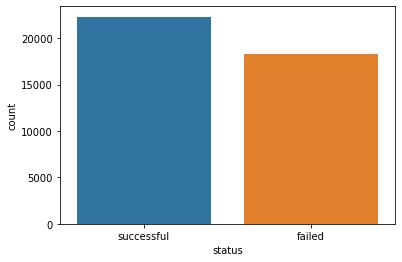

In [33]:
#make sure the value we are trying to calculate is binary
sns.countplot(x = 'status', data = final_data)
#check, each item is either successful or failed


In [34]:
#let's drop the reward levels column and the location column to make things easier for us.
#we are removing project name because I currently have no way to quanitify how good or bad a project name when read by the audience, therefore, making it impossible for me to currently estimate it's impact.
logreg_data = final_data.drop(columns=['location','reward_levels','url','project id','name','Day of Week','Funded Date','Funded Time'])
logreg_data

,category,subcategory,status,goal,pledged,funded percentage,backers,levels,updates,comments,duration
0,Film & Video,Short Film,successful,10500.0,11545.0,109.952381,66,7,10,2,30.00
1,Games,Board & Card Games,failed,4000.0,20.0,0.500000,2,5,6,0,47.18
2,Film & Video,Documentary,successful,6000.0,6535.0,108.916667,100,13,4,0,32.22
3,Fashion,Fashion,failed,3500.0,0.0,0.000000,0,6,2,0,30.00
4,Film & Video,Short Film,successful,3500.0,3582.0,102.333143,39,7,8,0,21.43
...,...,...,...,...,...,...,...,...,...,...,...
40595,Dance,Dance,successful,500.0,601.0,120.200000,13,3,2,0,37.83
40596,Music,Hip-Hop,failed,10000.0,75.0,0.750000,2,14,1,1,59.96
40597,Music,Rock,successful,10000.0,10000.0,100.000000,58,4,2,0,27.32
40598,Publishing,Fiction,failed,2999.0,257.0,8.569523,11,7,17,0,30.00


In [35]:
#I am also removing funding percentage and pledged ammounts because they highly correlate with whether or not something was successful
logreg_data = logreg_data.drop(columns=['funded percentage', 'pledged'])
logreg_data

,category,subcategory,status,goal,backers,levels,updates,comments,duration
0,Film & Video,Short Film,successful,10500.0,66,7,10,2,30.00
1,Games,Board & Card Games,failed,4000.0,2,5,6,0,47.18
2,Film & Video,Documentary,successful,6000.0,100,13,4,0,32.22
3,Fashion,Fashion,failed,3500.0,0,6,2,0,30.00
4,Film & Video,Short Film,successful,3500.0,39,7,8,0,21.43
...,...,...,...,...,...,...,...,...,...
40595,Dance,Dance,successful,500.0,13,3,2,0,37.83
40596,Music,Hip-Hop,failed,10000.0,2,14,1,1,59.96
40597,Music,Rock,successful,10000.0,58,4,2,0,27.32
40598,Publishing,Fiction,failed,2999.0,11,7,17,0,30.00


In [36]:
dummy_data = pd.get_dummies(logreg_data,columns=['category','subcategory','status'],drop_first = True)

In [37]:
# pd.set_option("max_columns", 70) #Showing only two columns
dummy_data

,goal,backers,levels,updates,comments,duration,category_Comics,category_Dance,category_Design,category_Fashion,...,subcategory_Publishing,subcategory_Rock,subcategory_Sculpture,subcategory_Short Film,subcategory_Technology,subcategory_Theater,subcategory_Video Games,subcategory_Webseries,subcategory_World Music,status_successful
0,10500.0,66,7,10,2,30.00,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,4000.0,2,5,6,0,47.18,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6000.0,100,13,4,0,32.22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3500.0,0,6,2,0,30.00,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3500.0,39,7,8,0,21.43,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40595,500.0,13,3,2,0,37.83,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
40596,10000.0,2,14,1,1,59.96,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40597,10000.0,58,4,2,0,27.32,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
40598,2999.0,11,7,17,0,30.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

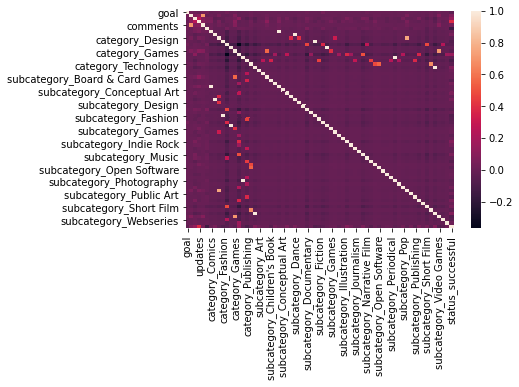

In [38]:
sns.heatmap(dummy_data.corr())
#Should I look into mutual information score or PCA?


In [39]:
#Let's look at the numbers associated with correlation, the closer to 1 a pair is, the more statistically correlated they are.
correlation_matrix=dummy_data.corr()
correlation_matrix

,goal,backers,levels,updates,comments,duration,category_Comics,category_Dance,category_Design,category_Fashion,...,subcategory_Publishing,subcategory_Rock,subcategory_Sculpture,subcategory_Short Film,subcategory_Technology,subcategory_Theater,subcategory_Video Games,subcategory_Webseries,subcategory_World Music,status_successful
goal,1.000000,0.035443,0.016345,-0.000637,0.033333,0.034539,-0.005176,-0.004807,0.004823,-0.003348,...,-0.002386,-0.008427,-0.002316,-0.007334,0.006356,-0.008272,0.014931,-0.000666,-0.002421,-0.036859
backers,0.035443,1.000000,0.074932,0.109898,0.705793,-0.006284,0.005939,-0.005786,0.045736,-0.007845,...,-0.005895,-0.005633,-0.002166,-0.016071,0.012293,-0.009664,0.083308,-0.002835,-0.002058,0.074310
levels,0.016345,0.074932,1.000000,0.261543,0.085806,0.040004,0.042204,-0.043217,-0.026505,-0.018517,...,-0.006190,0.049329,-0.012339,-0.049351,-0.006410,-0.060102,0.013807,0.007714,0.011629,0.142504
updates,-0.000637,0.109898,0.261543,1.000000,0.101306,0.053179,0.064854,-0.023186,0.046232,-0.036432,...,-0.015054,-0.022750,0.002832,-0.020886,0.006523,-0.042113,0.024197,-0.013047,-0.002708,0.388592
comments,0.033333,0.705793,0.085806,0.101306,1.000000,-0.006056,0.017557,-0.005237,0.026965,-0.004796,...,-0.004496,-0.004770,-0.002205,-0.011446,0.008692,-0.009526,0.089587,-0.003652,-0.002303,0.038145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subcategory_Theater,-0.008272,-0.009664,-0.060102,-0.042113,-0.009526,-0.026223,-0.037356,-0.032080,-0.048380,-0.038771,...,-0.029755,-0.049546,-0.021643,-0.076636,-0.021883,1.000000,-0.032852,-0.038771,-0.023302,0.078451
subcategory_Video Games,0.014931,0.083308,0.013807,0.024197,0.089587,-0.012653,-0.020617,-0.017705,-0.026700,-0.021397,...,-0.016421,-0.027344,-0.011945,-0.042295,-0.012077,-0.032852,1.000000,-0.021397,-0.012860,-0.064576
subcategory_Webseries,-0.000666,-0.002835,0.007714,-0.013047,-0.003652,-0.005034,-0.024331,-0.020895,-0.031511,-0.025253,...,-0.019380,-0.032271,-0.014097,-0.049915,-0.014253,-0.038771,-0.021397,1.000000,-0.015177,-0.040502
subcategory_World Music,-0.002421,-0.002058,0.011629,-0.002708,-0.002303,0.001691,-0.014624,-0.012558,-0.018939,-0.015177,...,-0.011648,-0.019395,-0.008472,-0.030000,-0.008566,-0.023302,-0.012860,-0.015177,1.000000,0.016855


In [40]:
correlation_matrix.loc[correlation_matrix['category_Design'] > 0.2,['category_Design']]
#we see that design subcategories are highly correlated to their category of design, this makes sense a projects limits the what subcategories a project could fit into.
#Therefore, I'm going to drop the category attribute while running my logistic regression



,category_Design
category_Design,1.000000
subcategory_Crafts,0.373088
subcategory_Design,0.402509
subcategory_Graphic Design,0.316213
subcategory_Product Design,0.758878


In [41]:
#pull out the values that we need to remove from the dummy data
category_list= correlation_matrix.filter(regex = '^category').iloc[0,:]

In [42]:
#Take the category dataframe we created above and transform it into a list.
category_columns_to_drop= list(category_list.index.values)
category_columns_to_drop

['category_Comics',
 'category_Dance',
 'category_Design',
 'category_Fashion',
 'category_Film & Video',
 'category_Food',
 'category_Games',
 'category_Music',
 'category_Photography',
 'category_Publishing',
 'category_Technology',
 'category_Theater']

In [43]:
#Let's drop time of day and funded date because I don't know how to account for these things yet
dummy_data= dummy_data.drop(columns= category_columns_to_drop)

In [44]:
#dummy_data.columns
#Double check to make sure category has been removed sucessfully, given our output we are given what we expect


In [45]:
X_train, X_test, y_train, y_test = train_test_split(dummy_data.drop('status_successful', axis=1),
                                                   dummy_data['status_successful'], test_size=0.2,
                                                   random_state=200)

In [46]:
print(X_train.shape)
print(X_train)


(32480, 54)
          goal  backers  levels  updates  comments  duration  subcategory_Art  \
27082   2000.0       43      10        4         7     30.00                0   
17216  11000.0       23      18        6         1     42.91                0   
27629   8600.0        9       7        0         0     21.00                0   
33528    400.0        0       4        0         0      6.96                0   
16605    300.0       12       1        0         2     19.25                0   
...        ...      ...     ...      ...       ...       ...              ...   
30939   5000.0        3       2        0         0     60.04                0   
11343   8000.0        1       7        0         0     28.00                0   
784     2500.0       92       9        0         4     58.03                0   
12905   1200.0       41       5        7         1     45.04                0   
1818    1500.0       33       5        5         2     28.03                0   

       subcateg

In [47]:
print(y_train.shape)
print(y_train)

(32480,)
27082    1
17216    0
27629    0
33528    0
16605    1
        ..
30939    0
11343    0
784      1
12905    1
1818     1
Name: status_successful, Length: 32480, dtype: uint8


In [48]:
##Apply feature scaling to the model
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [49]:
#Look up what these functions do
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [50]:
#Look up what these functions do
y_pred = LogReg.predict(X_test)

In [51]:
## Model Evaluation
### Classification report without cross-validation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      3696
           1       0.92      0.91      0.91      4424

    accuracy                           0.91      8120
   macro avg       0.90      0.91      0.91      8120
weighted avg       0.91      0.91      0.91      8120



In [52]:
### K-fold cross-validation & confusion matrices
#calculate the prediction score for your training set
y_train_pred = cross_val_predict(LogReg, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[13091,  1491],
       [ 1538, 16360]], dtype=int64)

In [53]:
precision_score(y_train, y_train_pred)

0.9164752674920172

In [54]:
## Model Evaluation
### Classification report with cross-validation
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90     14582
           1       0.92      0.91      0.92     17898

    accuracy                           0.91     32480
   macro avg       0.91      0.91      0.91     32480
weighted avg       0.91      0.91      0.91     32480



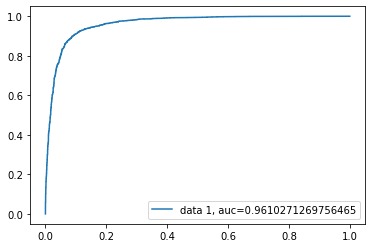

In [55]:
y_pred_proba = LogReg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [56]:
print('Coefficient Matrix')
print(LogReg.coef_)
# coefficients = pd.Dataframe
print('')
print('Training Data column names')
print(dummy_data.columns)


Coefficient Matrix
[[-3.25906256e+01  3.81987023e+01 -1.11002696e-01  1.20652422e+00
   4.09198664e+00 -2.83617906e-01  7.60684967e-02  7.10303416e-03
  -1.62238914e-01 -9.02983310e-02  1.29544957e-01 -4.26040709e-02
   4.77002396e-02  1.41952928e-01 -3.44548504e-03  1.74100523e-01
  -4.04489440e-03  1.65790246e-02  1.04898673e-01  3.90156065e-02
  -4.58993171e-02 -5.51663485e-02  1.33356415e-01  6.96467373e-03
  -3.06550801e-02  5.62797118e-04 -4.22406592e-03  2.58944524e-02
   2.28546098e-01  1.00360170e-01  2.41957713e-02  2.63810602e-02
   1.96918932e-01  1.21855002e-01 -4.27643985e-02 -4.88163580e-02
  -5.65496444e-02  4.15052172e-02  7.06554728e-02  2.64210537e-02
   1.49675682e-02  1.06524803e-02  1.00618204e-01 -1.81391496e-01
   6.96891119e-02 -1.71397784e-02  2.03373391e-01  3.79907156e-02
   2.73068122e-01 -8.97198473e-02  2.77417844e-01 -1.88906607e-01
   1.70364796e-02  4.93069209e-02]]

Training Data column names
Index(['goal', 'backers', 'levels', 'updates', 'comments', 

In [57]:
#The coefficient dataframe from the logistic regression model does not have column names associated with it, 
# which makes it hard to quickly identify which variable corresponds to which weight.
# 
# Fortunately, the coefficients are created in the order in which the logistic regression model received them, 
# which our dummy_data data frame was used to determine.
# So we can combine the coefficent matrix and use the column names from dummy_data to create a dataframe of variable weights.

column_names = dummy_data.drop('status_successful', axis=1).columns #we have to drop the 'status_successful' column because it was originally included in the dummy_data data frame. there is no weight assigned to "status_successful" becasue that's the variable we are trying to calculate.

print(column_names)

#create a new list of column names that shortens the subcategory names
new_column_names= []

for column in column_names:
    new_name = column.replace("subcategory",'sc')
    new_column_names.append(new_name)
    # print(new_column_names) Used for testing our new list

# subcat_list = ['goal','backers', 'levels', 'updates', 'comments', 'duration', 'sc_Art', 'sc_Art Book', 'sc_Board & Card Games', 'sc_Childrens Book', 'sc_Classical Music', 'sc_Comics', 'sc_Conceptual Art', 
# 'sc_Country & Folk', 'sc_Crafts', 'sc_Dance', 'sc_Design', 'sc_Digital Art', 'sc_Documentary', 
# 'sc_Electronic Music', 'sc_Fashion', 'sc_Fiction', 'sc_Film & Video', 'sc_Food', 'sc_Games',
# 'sc_Graphic Design', 'sc_Hip-Hop', 'sc_Illustration', 'sc_Indie Rock', 'sc_Jazz', 'sc_Journalism', 
# 'sc_Mixed Media', 'sc_Music', 'sc_Narrative Film', 'sc_Nonfiction', 'sc_Open Hardware', 'sc_Open Software',
# 'sc_Painting', 'sc_Performance Art', 'sc_Periodical', 'sc_Photography', 'sc_Poetry', 'sc_Pop', 'sc_Product Design', 
# 'sc_Public Art', 'sc_Publishing', 'sc_Rock', 'sc_Sculpture', 'sc_Short Film', 'sc_Technology', 'sc_Theater', 'sc_Video Games',
# 'sc_Webseries', 'sc_World Music']


# print(subcat_list)

Index(['goal', 'backers', 'levels', 'updates', 'comments', 'duration',
       'subcategory_Art', 'subcategory_Art Book',
       'subcategory_Board & Card Games', 'subcategory_Children's Book',
       'subcategory_Classical Music', 'subcategory_Comics',
       'subcategory_Conceptual Art', 'subcategory_Country & Folk',
       'subcategory_Crafts', 'subcategory_Dance', 'subcategory_Design',
       'subcategory_Digital Art', 'subcategory_Documentary',
       'subcategory_Electronic Music', 'subcategory_Fashion',
       'subcategory_Fiction', 'subcategory_Film & Video', 'subcategory_Food',
       'subcategory_Games', 'subcategory_Graphic Design',
       'subcategory_Hip-Hop', 'subcategory_Illustration',
       'subcategory_Indie Rock', 'subcategory_Jazz', 'subcategory_Journalism',
       'subcategory_Mixed Media', 'subcategory_Music',
       'subcategory_Narrative Film', 'subcategory_Nonfiction',
       'subcategory_Open Hardware', 'subcategory_Open Software',
       'subcategory_Painting'

In [58]:
##Creation of our coefficient dataframe
coeff_df = pd.DataFrame(LogReg.coef_, columns = new_column_names)
coeff_df.head()

,goal,backers,levels,updates,comments,duration,sc_Art,sc_Art Book,sc_Board & Card Games,sc_Children's Book,...,sc_Public Art,sc_Publishing,sc_Rock,sc_Sculpture,sc_Short Film,sc_Technology,sc_Theater,sc_Video Games,sc_Webseries,sc_World Music
0,-32.590626,38.198702,-0.111003,1.206524,4.091987,-0.283618,0.076068,0.007103,-0.162239,-0.090298,...,0.069689,-0.01714,0.203373,0.037991,0.273068,-0.08972,0.277418,-0.188907,0.017036,0.049307


In [59]:
#Lets reshape the matrix so that it's one column and multiple rows.
coeff_df_transpose= coeff_df.transpose().rename(columns={0:"Weights with Backers"}, errors="raise")
print(coeff_df_transpose)
#next step, let's sort the rows by their value

                       Weights with Backers
goal                             -32.590626
backers                           38.198702
levels                            -0.111003
updates                            1.206524
comments                           4.091987
duration                          -0.283618
sc_Art                             0.076068
sc_Art Book                        0.007103
sc_Board & Card Games             -0.162239
sc_Children's Book                -0.090298
sc_Classical Music                 0.129545
sc_Comics                         -0.042604
sc_Conceptual Art                  0.047700
sc_Country & Folk                  0.141953
sc_Crafts                         -0.003445
sc_Dance                           0.174101
sc_Design                         -0.004045
sc_Digital Art                     0.016579
sc_Documentary                     0.104899
sc_Electronic Music                0.039016
sc_Fashion                        -0.045899
sc_Fiction                      

In [60]:
coeff_df_transpose.sort_values('Weights with Backers')
#backers has the highest positive weight of 38,
#Comments had the positive wieght of 4,
#updates had a positive weight of 1.207
#Goal amount had a negative weight of -32.5, followed by duration at -0.2863


,Weights with Backers
goal,-32.590626
duration,-0.283618
sc_Video Games,-0.188907
sc_Product Design,-0.181391
sc_Board & Card Games,-0.162239
levels,-0.111003
sc_Children's Book,-0.090298
sc_Technology,-0.089720
sc_Open Software,-0.056550
sc_Fiction,-0.055166


In [61]:
#THIS LINE OF CODE IS NO LONGER APPLICABLE SINCE WE REMOVED CATEGORIES FROM OUR MODEL
#Pull out category weights 
# category_weights = coeff_df_transpose.filter(regex = "^category", axis=0)
# category_weights.sort_values('Weights with Backers', ascending = False)
# #Having the category of either Music, theater, or dance had a net positive effect,
# #while everything else had a negative effect on the ability to succeed.


In [62]:
#A function to easily generate an array that has the value set to 1 only for the category you want. goal amount, levels, and updates 
def Backers_TestCaseGen(goal, backers, levels, updates, comments, duration, desired_subcategory):
    parameter_list = ['goal', 'backers','levels', 'updates', 'comments', 'duration', 'sc_Art','sc_Art Book', 'sc_Board & Card Games', 'sc_Childrens Book','sc_Classical Music', 'sc_Comics', 'sc_Conceptual Art','sc_Country & Folk', 'sc_Crafts', 'sc_Dance', 'sc_Design','sc_Digital Art', 'sc_Documentary', 'sc_Electronic Music', 'sc_Fashion','sc_Fiction', 'sc_Film & Video', 'sc_Food', 'sc_Games','sc_Graphic Design', 'sc_Hip-Hop', 'sc_Illustration', 'sc_Indie Rock','sc_Jazz', 'sc_Journalism', 'sc_Mixed Media', 'sc_Music','sc_Narrative Film', 'sc_Nonfiction', 'sc_Open Hardware','sc_Open Software', 'sc_Painting', 'sc_Performance Art','sc_Periodical', 'sc_Photography', 'sc_Poetry', 'sc_Pop','sc_Product Design', 'sc_Public Art', 'sc_Publishing', 'sc_Rock','sc_Sculpture', 'sc_Short Film', 'sc_Technology', 'sc_Theater','sc_Video Games', 'sc_Webseries', 'sc_World Music']
    pointer = parameter_list.index(desired_subcategory)
    generated_test_case = np.zeros(len(parameter_list))
    generated_test_case[pointer] = 1
    generated_test_case[0] = goal
    generated_test_case[1] = backers
    generated_test_case[2] = levels
    generated_test_case[3] = updates
    generated_test_case[4] = comments
    generated_test_case[5] = duration
    return sc.transform(generated_test_case.reshape(1,-1))

In [63]:
# #Pull out subcategory weights
# subcategory_weights = coeff_df_transpose.filter(regex = "^subcategory", axis=0)
# subcategory_weights.sort_values('Weights with Backers', ascending = False)
# #Short film had the most postiive effect

<Figure size 432x288 with 0 Axes>

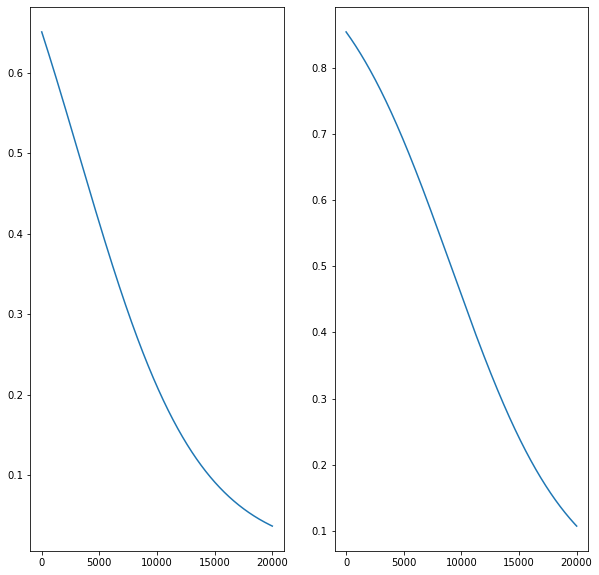

In [64]:
#Currently plotting just how success rate changes given the amount of money you raise



plt.clf()

gta = 20000 # gta = goal test amount

fig = plt.figure(figsize =(10, 10))


sub1 = plt.subplot(1, 2, 1)
sub2 = plt.subplot(1, 2, 2)

predicted_success = np.zeros(gta)

for x in range(gta):
    test_case = Backers_TestCaseGen(x,0,0,0,0,0,'sc_Theater')
    predicted_success[x] = LogReg.predict_proba(test_case.reshape(1,-1))[0][1]
x_values = list(range(gta))    
y = predicted_success.reshape(-1,1)
sub1.plot(x_values, y)


# as we can see, we see an extreme drop off once we get a threshold value

for x in range(gta):
    test_case = Backers_TestCaseGen(x,5,5,5,5,0,'sc_Theater')
    predicted_success[x] = LogReg.predict_proba(test_case.reshape(1,-1))[0][1]
x_values = list(range(gta))    
y = predicted_success.reshape(-1,1)
sub2.plot(x_values, y)

### Lets see what we get when you pull-out category and the number of backers from our model ###

In [65]:
#Get dummies is function built into pandas that will create binary columns for us for categorical variables.

dummy_data = pd.get_dummies(logreg_data,columns=['subcategory','status'],drop_first = True)
#Let's drop time of day and funded date because I don't know how to account for these things yet
#let's also get rid of backers because of how strong of an impact it had on everything. 
#Let's get rid of category to see just how important subcategory is for this analysis
dummy_data= dummy_data.drop(columns= ["backers",'category'])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(dummy_data.drop('status_successful', axis=1),
                                                   dummy_data['status_successful'], test_size=0.2,
                                                   random_state=200)
print(X_train.shape)
print(X_train)


(32480, 53)
          goal  levels  updates  comments  duration  subcategory_Art  \
27082   2000.0      10        4         7     30.00                0   
17216  11000.0      18        6         1     42.91                0   
27629   8600.0       7        0         0     21.00                0   
33528    400.0       4        0         0      6.96                0   
16605    300.0       1        0         2     19.25                0   
...        ...     ...      ...       ...       ...              ...   
30939   5000.0       2        0         0     60.04                0   
11343   8000.0       7        0         0     28.00                0   
784     2500.0       9        0         4     58.03                0   
12905   1200.0       5        7         1     45.04                0   
1818    1500.0       5        5         2     28.03                0   

       subcategory_Art Book  subcategory_Board & Card Games  \
27082                     0                               0 

In [67]:
print(y_train.shape)
print(y_train)

(32480,)
27082    1
17216    0
27629    0
33528    0
16605    1
        ..
30939    0
11343    0
784      1
12905    1
1818     1
Name: status_successful, Length: 32480, dtype: uint8


In [68]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
LogReg = LogisticRegression(solver='liblinear',class_weight = 'balanced')
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

In [69]:
## Model Evaluation
### Classification report without cross-validation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      3696
           1       0.86      0.80      0.83      4424

    accuracy                           0.82      8120
   macro avg       0.82      0.82      0.82      8120
weighted avg       0.82      0.82      0.82      8120



In [70]:
### K-fold cross-validation & confusion matrices
#calculate the prediction score for your training set
y_train_pred = cross_val_predict(LogReg, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[12262,  2320],
       [ 3516, 14382]], dtype=int64)

In [71]:
precision_score(y_train, y_train_pred)

0.8610944797030295

In [72]:
#Classification report with cross-validation
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81     14582
           1       0.86      0.80      0.83     17898

    accuracy                           0.82     32480
   macro avg       0.82      0.82      0.82     32480
weighted avg       0.82      0.82      0.82     32480



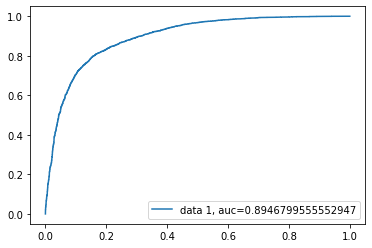

In [73]:
#Create an ROC curve to assess the tradeoff between sensitivity and specificity
y_pred_proba = LogReg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [74]:
#Save my coefficients into a pretty dataframe
column_names = (dummy_data.drop('status_successful', axis=1).columns)
hardcode_columns = ['goal', 'levels', 'updates', 'comments', 'duration', 'sc_Art',
'sc_Art Book', 'sc_Board & Card Games',
'sc_Childrens Book', 'sc_Classical Music',
'sc_Comics', 'sc_Conceptual Art',
'sc_Country & Folk', 'sc_Crafts', 'sc_Dance',
'sc_Design', 'sc_Digital Art',
'sc_Documentary', 'sc_Electronic Music',
'sc_Fashion', 'sc_Fiction',
'sc_Film & Video', 'sc_Food', 'sc_Games',
'sc_Graphic Design', 'sc_Hip-Hop',
'sc_Illustration', 'sc_Indie Rock',
'sc_Jazz', 'sc_Journalism', 'sc_Mixed Media',
'sc_Music', 'sc_Narrative Film',
'sc_Nonfiction', 'sc_Open Hardware',
'sc_Open Software', 'sc_Painting',
'sc_Performance Art', 'sc_Periodical',
'sc_Photography', 'sc_Poetry', 'sc_Pop',
'sc_Product Design', 'sc_Public Art',
'sc_Publishing', 'sc_Rock', 'sc_Sculpture',
'sc_Short Film', 'sc_Technology',
'sc_Theater', 'sc_Video Games',
'sc_Webseries', 'sc_World Music']

no_backers_coeff_df = pd.DataFrame(LogReg.coef_, columns = hardcode_columns)





no_backers_coeff_df = no_backers_coeff_df

print(no_backers_coeff_df.columns)

Index(['goal', 'levels', 'updates', 'comments', 'duration', 'sc_Art',
       'sc_Art Book', 'sc_Board & Card Games', 'sc_Childrens Book',
       'sc_Classical Music', 'sc_Comics', 'sc_Conceptual Art',
       'sc_Country & Folk', 'sc_Crafts', 'sc_Dance', 'sc_Design',
       'sc_Digital Art', 'sc_Documentary', 'sc_Electronic Music', 'sc_Fashion',
       'sc_Fiction', 'sc_Film & Video', 'sc_Food', 'sc_Games',
       'sc_Graphic Design', 'sc_Hip-Hop', 'sc_Illustration', 'sc_Indie Rock',
       'sc_Jazz', 'sc_Journalism', 'sc_Mixed Media', 'sc_Music',
       'sc_Narrative Film', 'sc_Nonfiction', 'sc_Open Hardware',
       'sc_Open Software', 'sc_Painting', 'sc_Performance Art',
       'sc_Periodical', 'sc_Photography', 'sc_Poetry', 'sc_Pop',
       'sc_Product Design', 'sc_Public Art', 'sc_Publishing', 'sc_Rock',
       'sc_Sculpture', 'sc_Short Film', 'sc_Technology', 'sc_Theater',
       'sc_Video Games', 'sc_Webseries', 'sc_World Music'],
      dtype='object')


In [75]:
df2 = {'backers': 'NA'}
no_backers_coeff_df = no_backers_coeff_df.append(df2,ignore_index=True)

# print(no_backers_coeff_df)

In [76]:
#Transpose the dataframe to make it easier to read


# print(no_backers_coeff_df)
no_backers_coeff_df_transpose= no_backers_coeff_df.transpose()

# print(no_backers_coeff_df_transpose)


no_backers_coeff_df_transpose.drop(columns = [1],inplace=True)




no_backers_coeff_df_transpose= no_backers_coeff_df_transpose.rename(columns={0:"Weights with No Backers"}, errors="raise")
# no_backers_coeff_df_transpose.sort_values('Weights with No Backers')

In [77]:
#Let's take the weights from the training model before and after we removed # of backers and categories from the equation
#Let's see how it differs.
weight_compare = pd.merge(coeff_df_transpose, no_backers_coeff_df_transpose, left_index= True, right_index=True)


weight_comparison = weight_compare.sort_values(by = 'Weights with Backers',inplace= False)
# print(weight_comparison)


In [78]:
#Currently attempting of converting weights into their respective probabilities

weight_comparison['Weights with Backers'][0]
# np.exp(weight_comparison['Weights with Backers'][0])
print(weight_comparison['Weights with No Backers']['backers'])

print(np.exp(weight_comparison['Weights with No Backers']['backers']))

nan
nan


In [79]:
#Recalculate coefficients to represent odds rather than the logit
#this is calcualted using odds = exp(coefficient)

# odds_comparison = weight_comparison
# odds_comparison['Weights with Backers'] = math.exp(odds_comparison['Weights with Backers'])
# print(odds_comparison.iloc[0,0])

# odds_comparison = pd.DataFrame(columns = ['Weights with Backers', 'Weights With No Backers'])
# # odds_comparison.head()
# for x in weight_comparison['Weights with Backers']:
# #     print(x)
#     weight_comparison['Odds with Backers'] = math.exp(x)
#     print(weight_comparison['Odds with Backers'])
    

# odds_comparison = weight_comparison.copy()
weight_comparison['Odds with Backers'] = np.exp(weight_comparison['Weights with Backers'])


# weight_comparison['Odds with No Backers'] = np.exp(weight_comparison['Weights with No Backers'])


weight_comparison.iloc[:,0:2]

,Weights with Backers,Weights with No Backers
goal,-32.590626,-18.96564
duration,-0.283618,-0.35111
sc_Video Games,-0.188907,-0.257696
sc_Product Design,-0.181391,-0.142067
sc_Board & Card Games,-0.162239,-0.152619
levels,-0.111003,0.133294
sc_Technology,-0.089720,-0.065072
sc_Open Software,-0.056550,-0.028959
sc_Fiction,-0.055166,-0.084006
sc_Open Hardware,-0.048816,-0.05188


<AxesSubplot:ylabel='Weights with Backers'>

<Figure size 432x288 with 0 Axes>

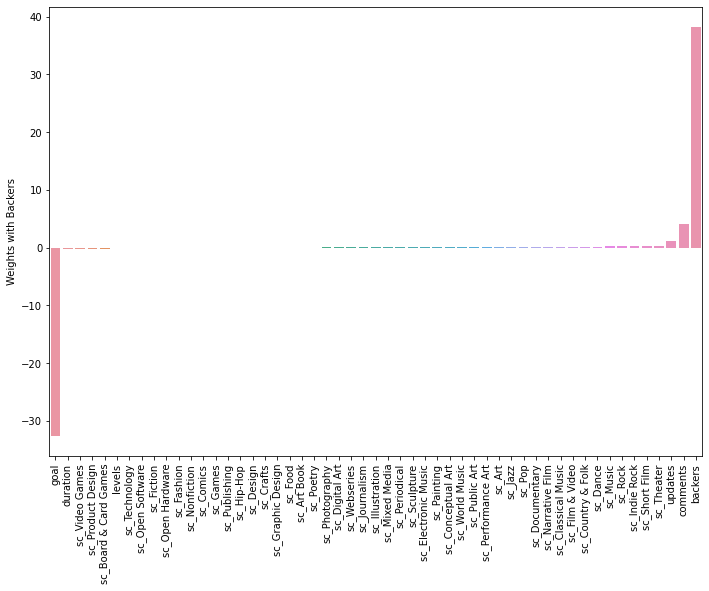

In [80]:
plt.clf()

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=90)
sns.barplot(x= weight_comparison['Weights with Backers'].index, y=  weight_comparison['Weights with Backers'])

<Figure size 432x288 with 0 Axes>

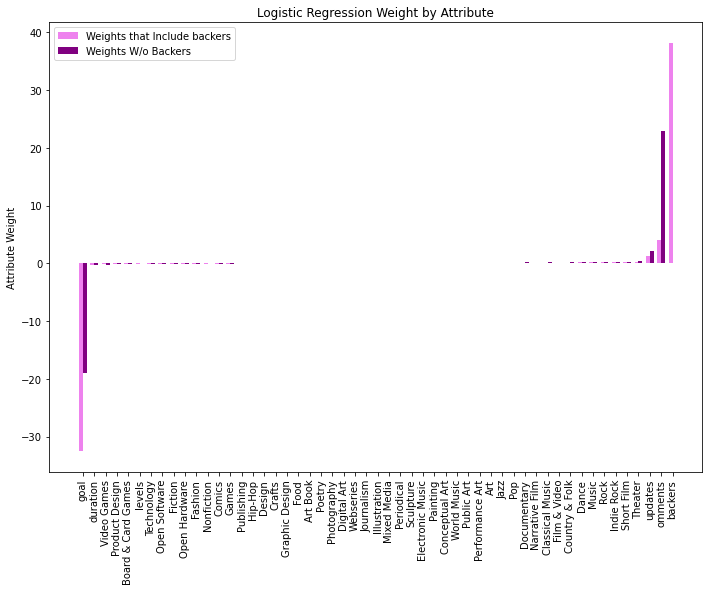

In [81]:
#Let's do a Grouped chart with all the variables
#As expected the chart is difficult to read due to the large difference in values, so we are going to create two additional charts,
#one chart will only include subcategory weights while the other will have everything else.


plt.clf()
labels = weight_comparison.index

new_labels =[]
for item in labels:
    new_labels.append(item.lstrip('sc_'))

# print(new_labels)

x = np.arange(len(new_labels))  # the label locations
width = 0.35  # the width of the bars
a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)


rects1 = ax.bar(x - width/2,  weight_comparison['Weights with Backers'], width, label='Weights that Include backers', color = 'violet')
rects2 = ax.bar(x + width/2, weight_comparison['Weights with No Backers'], width, label='Weights W/o Backers', color = 'purple')

plt.xticks(rotation=90)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Attribute Weight')
ax.set_title('Logistic Regression Weight by Attribute')
ax.set_xticks(x)
ax.set_xticklabels(new_labels)
ax.legend()

<Figure size 432x288 with 0 Axes>

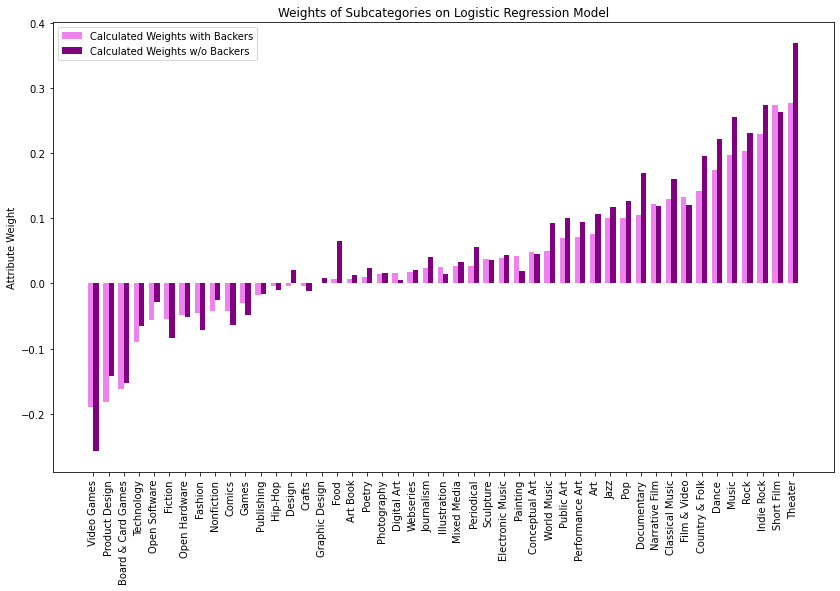

In [82]:
#let's pull out all the values associated only with the subcategory weights

final_weights_subcategory = weight_comparison.filter(like='_', axis =0)

plt.clf()
labels = final_weights_subcategory.index

new_labels = []

for label in labels:
    new_labels.append(label.lstrip('sc_'))

x = np.arange(len(new_labels))  # the label locations
width = 0.35  # the width of the bars
a4_dims = (14, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)


rects1 = ax.bar(x - width/2, final_weights_subcategory['Weights with Backers'], width, label='Calculated Weights with Backers', color = 'violet')
rects2 = ax.bar(x + width/2, final_weights_subcategory['Weights with No Backers'], width, label='Calculated Weights w/o Backers', color = 'purple')

plt.xticks(rotation=90)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Attribute Weight')
ax.set_title('Weights of Subcategories on Logistic Regression Model')
ax.set_xticks(x)
ax.set_xticklabels(new_labels)
ax.legend()

<Figure size 432x288 with 0 Axes>

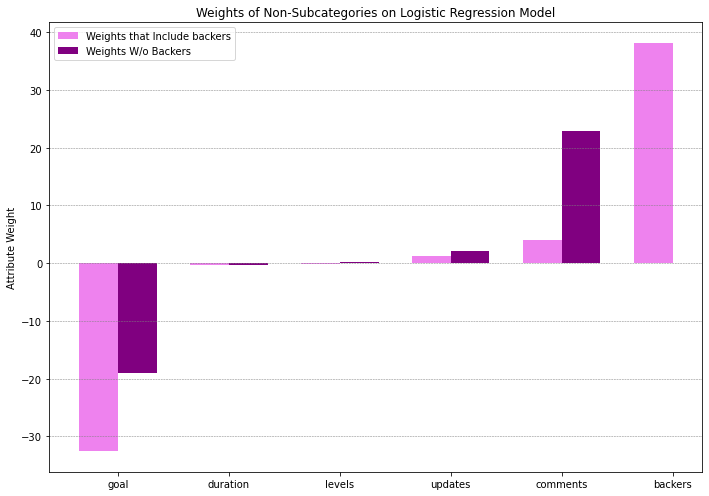

In [83]:
#We graphed all the subcategories above
#Let's go ahead and graph our values for the non subcategories entries
#let's pull out all the values associated only with the subcategory weights

final_weights_subcategory = weight_comparison.filter(items=['goal','duration','levels','updates','comments','backers'], axis =0 )

plt.clf()
labels = final_weights_subcategory.index


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)


rects1 = ax.bar(x - width/2, final_weights_subcategory['Weights with Backers'], width, label='Weights that Include backers', color = 'violet')
rects2 = ax.bar(x + width/2, final_weights_subcategory['Weights with No Backers'], width, label='Weights W/o Backers', color = 'purple')


# Add some text for labels, title and custom x-axis tick labels, etc.
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, axis = 'y')

ax.set_ylabel('Attribute Weight')
ax.set_title('Weights of Non-Subcategories on Logistic Regression Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

### Creating predictions for hypothetical projects using Weights for No Backers



In [84]:
# To predict probability of a project working, run the line of code "LogReg.predict_proba([List of parameter values])
# Use the function TestCaseGen to create an array of parameter values to use with LogReg.predict_proba


In [85]:
#A function to easily generate an array that has the value set to 1 only for the category you want. goal amount, levels, and updates 
def NoBackers_TestCaseGen(goal, levels, updates, comments, duration, desired_subcategory):
    parameter_list = ['goal', 'levels', 'updates', 'comments', 'duration', 'sc_Art','sc_Art Book', 'sc_Board & Card Games', 'sc_Childrens Book','sc_Classical Music', 'sc_Comics', 'sc_Conceptual Art','sc_Country & Folk', 'sc_Crafts', 'sc_Dance', 'sc_Design','sc_Digital Art', 'sc_Documentary', 'sc_Electronic Music', 'sc_Fashion','sc_Fiction', 'sc_Film & Video', 'sc_Food', 'sc_Games','sc_Graphic Design', 'sc_Hip-Hop', 'sc_Illustration', 'sc_Indie Rock','sc_Jazz', 'sc_Journalism', 'sc_Mixed Media', 'sc_Music','sc_Narrative Film', 'sc_Nonfiction', 'sc_Open Hardware','sc_Open Software', 'sc_Painting', 'sc_Performance Art','sc_Periodical', 'sc_Photography', 'sc_Poetry', 'sc_Pop','sc_Product Design', 'sc_Public Art', 'sc_Publishing', 'sc_Rock','sc_Sculpture', 'sc_Short Film', 'sc_Technology', 'sc_Theater','sc_Video Games', 'sc_Webseries', 'sc_World Music']
    generated_test_case = np.zeros(len(parameter_list))
    generated_test_case[0] = goal
    generated_test_case[1] = levels
    generated_test_case[2] = updates
    generated_test_case[3] = comments
    generated_test_case[4] = duration
    if desired_subcategory != 'sc_Animation':
        pointer = parameter_list.index(desired_subcategory)
        generated_test_case[pointer] = 1
    
    return sc.transform(generated_test_case.reshape(1,-1))
    


In [86]:
# print(results)
# results
NoBackers_TestCaseGen(0,0,0,0,0,'sc_Animation')


array([[-0.06450755, -1.89549979, -0.65986499, -0.04818022, -2.28771007,
        -0.15717078, -0.08555227, -0.1082217 , -0.11487056, -0.10177753,
        -0.15258503, -0.06460458, -0.15332289, -0.07381221, -0.13112331,
        -0.07910836, -0.05612742, -0.30630649, -0.08124759, -0.15931727,
        -0.15300706, -0.24625331, -0.17933113, -0.07670837, -0.06290055,
        -0.1013133 , -0.06436386, -0.21405368, -0.09927762, -0.09257626,
        -0.09896087, -0.27978859, -0.18483603, -0.14557119, -0.06508339,
        -0.07189018, -0.10763781, -0.10660866, -0.08066965, -0.18142385,
        -0.06856972, -0.12705574, -0.15120602, -0.11123918, -0.12156487,
        -0.2032059 , -0.0893066 , -0.31257836, -0.09086957, -0.24512613,
        -0.13590129, -0.15747904, -0.09573798]])

<Figure size 432x288 with 0 Axes>

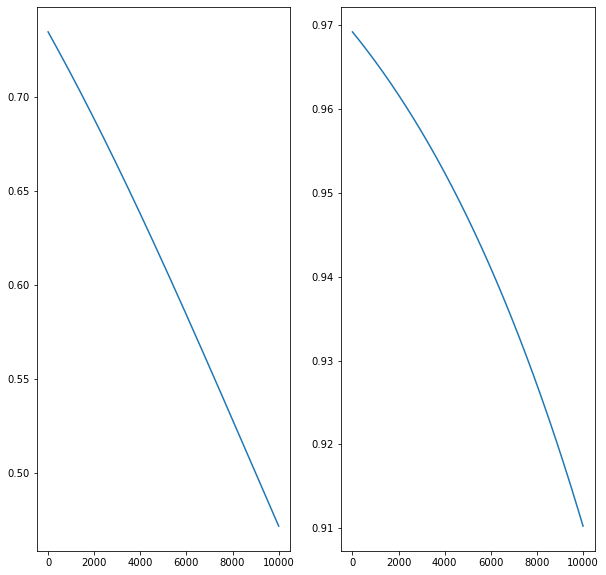

In [87]:
#Currently plotting just how success rate changes given the amount of money you raise



plt.clf()

gta = 10000 # gta = goal test amount

fig = plt.figure(figsize =(10, 10))


sub1 = plt.subplot(1, 2, 1)
sub2 = plt.subplot(1, 2, 2)

predicted_success = np.zeros(gta)

for x in range(gta):
    test_case = NoBackers_TestCaseGen(x,0,0,0,0,'sc_Theater')
    predicted_success[x] = LogReg.predict_proba(test_case.reshape(1,-1))[0][1]
x_values = list(range(gta))    
y = predicted_success.reshape(-1,1)
sub1.plot(x_values, y)


# as we can see, we see an extreme drop off once we get a threshold value

for x in range(gta):
    test_case = NoBackers_TestCaseGen(x,5,5,5,0,'sc_Theater')
    predicted_success[x] = LogReg.predict_proba(test_case.reshape(1,-1))[0][1]
x_values = list(range(gta))    
y = predicted_success.reshape(-1,1)
sub2.plot(x_values, y)

### Updating my logistic regression model to not have outliers

Originally I was having issues getting accurate results from my model and I assumed that it was because of the outliers in the data. It turns out that I wasn't properly scalling my input features like I needed to! 

In [88]:
# quartile_range= (final_data['goal'].percentile(75) - final_data['goal'].percentile(75))
iq_range= np.percentile(dummy_data['goal'],75) - np.percentile(dummy_data['goal'],25)
outlier_limit = 1.5*iq_range +np.percentile(dummy_data['goal'],75)
print(outlier_limit)

19950.0


In [89]:
no_outlier_dd = dummy_data.loc[dummy_data['goal'] <= (2*outlier_limit)].copy()


In [90]:
no_outlier_dd

,goal,levels,updates,comments,duration,subcategory_Art,subcategory_Art Book,subcategory_Board & Card Games,subcategory_Children's Book,subcategory_Classical Music,...,subcategory_Publishing,subcategory_Rock,subcategory_Sculpture,subcategory_Short Film,subcategory_Technology,subcategory_Theater,subcategory_Video Games,subcategory_Webseries,subcategory_World Music,status_successful
0,10500.0,7,10,2,30.00,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,4000.0,5,6,0,47.18,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6000.0,13,4,0,32.22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3500.0,6,2,0,30.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3500.0,7,8,0,21.43,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40595,500.0,3,2,0,37.83,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
40596,10000.0,14,1,1,59.96,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40597,10000.0,4,2,0,27.32,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
40598,2999.0,7,17,0,30.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
X_train, X_test, y_train, y_test = train_test_split(no_outlier_dd.drop('status_successful', axis=1),
                                                   no_outlier_dd['status_successful'], test_size=0.2,
                                                   random_state=200)

In [92]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
no_outlier_logreg = LogisticRegression(solver='lbfgs')
no_outlier_logreg.fit(X_train, y_train)
y_pred = no_outlier_logreg.predict(X_test)

In [93]:
# print(y_pred)
sc.mean_

array([6.01057155e+03, 7.90574661e+00, 4.26630018e+00, 5.39174763e+00,
       3.95896155e+01, 2.43863462e-02, 7.35106111e-03, 1.14740476e-02,
       1.31999489e-02, 1.06110969e-02, 2.41306571e-02, 3.89925850e-03,
       2.47059576e-02, 5.33750959e-03, 1.75786244e-02, 5.84888775e-03,
       3.00434671e-03, 8.11493224e-02, 6.90360522e-03, 2.47698798e-02,
       2.26924060e-02, 5.23843007e-02, 3.09383789e-02, 5.56123754e-03,
       3.86729737e-03, 1.05152135e-02, 4.15494758e-03, 4.53848121e-02,
       1.00677576e-02, 8.75735106e-03, 1.02275633e-02, 7.40219893e-02,
       2.94042444e-02, 2.04551266e-02, 3.70749169e-03, 5.30554845e-03,
       1.19534646e-02, 1.18256200e-02, 6.20046024e-03, 3.28560470e-02,
       4.85809256e-03, 1.74507799e-02, 2.05190488e-02, 1.27205318e-02,
       1.48619279e-02, 4.12937868e-02, 8.05420609e-03, 9.28790591e-02,
       6.80772181e-03, 5.75300435e-02, 1.65878292e-02, 2.42904628e-02,
       9.07696241e-03])

In [94]:
## Model Evaluation
### Classification report without cross-validation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      3361
           1       0.85      0.86      0.85      4462

    accuracy                           0.83      7823
   macro avg       0.83      0.83      0.83      7823
weighted avg       0.83      0.83      0.83      7823



In [95]:
### K-fold cross-validation & confusion matrices
#calculate the prediction score for your training set
y_train_pred = cross_val_predict(no_outlier_logreg, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

#Classification report with cross-validation
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     13676
           1       0.84      0.85      0.85     17612

    accuracy                           0.82     31288
   macro avg       0.82      0.82      0.82     31288
weighted avg       0.82      0.82      0.82     31288



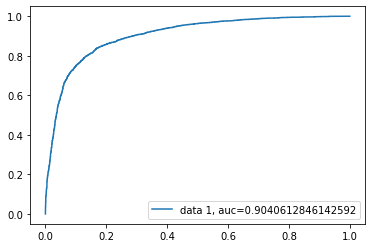

In [96]:
#Create an ROC curve to assess the tradeoff between sensitivity and specificity
y_pred_proba = no_outlier_logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [97]:
print(no_outlier_logreg.coef_)
coed_df= no_outlier_dd.drop('status_successful',axis=1).columns
print(coed_df)

[[-1.25472955e+00  1.53977263e-01  2.09219412e+00  1.61284945e+01
  -3.29388738e-01  9.28975252e-02  1.45694965e-02 -1.85411965e-01
  -8.69940164e-02  1.67511120e-01 -1.05036598e-01  3.92073062e-02
   1.68408401e-01 -5.34472136e-02  1.95361345e-01  1.24293491e-02
   5.32115462e-04  1.77211582e-01  2.40268925e-02 -9.17379187e-02
  -1.05586654e-01  1.11135981e-01  6.91652789e-02 -7.57726618e-02
  -5.29080881e-03 -2.58494320e-02 -6.91259494e-03  2.29461012e-01
   1.03449097e-01  1.97237941e-02 -6.78027889e-03  2.03718498e-01
   1.24610758e-01 -4.65150433e-02 -7.54128393e-02 -4.81760485e-02
  -2.14057097e-03  1.00602285e-01  4.77683271e-02 -1.09920346e-04
   1.47018379e-02  1.15534087e-01 -2.15871419e-01  8.96015028e-02
  -3.40401176e-02  1.86812111e-01  1.64696870e-02  2.41574705e-01
  -6.93629880e-02  3.40749397e-01 -2.90655641e-01  3.10609737e-03
   7.10616455e-02]]
Index(['goal', 'levels', 'updates', 'comments', 'duration', 'subcategory_Art',
       'subcategory_Art Book', 'subcategory

In [98]:
##Creation of our coefficient dataframe
no_outlier_coeff_df = pd.DataFrame(no_outlier_logreg.coef_, columns = coed_df)
no_outlier_coeff_df.head()


#updated weights make a ton of sense with comments being the strongest indicator or project success, this makes sense because comments can be used as a secondary effect measure of project popularity.


,goal,levels,updates,comments,duration,subcategory_Art,subcategory_Art Book,subcategory_Board & Card Games,subcategory_Children's Book,subcategory_Classical Music,...,subcategory_Public Art,subcategory_Publishing,subcategory_Rock,subcategory_Sculpture,subcategory_Short Film,subcategory_Technology,subcategory_Theater,subcategory_Video Games,subcategory_Webseries,subcategory_World Music
0,-1.25473,0.153977,2.092194,16.128495,-0.329389,0.092898,0.014569,-0.185412,-0.086994,0.167511,...,0.089602,-0.03404,0.186812,0.01647,0.241575,-0.069363,0.340749,-0.290656,0.003106,0.071062


### Let's now test to see if these weight actually produce accruate results

In [99]:
no_outlier_dd

,goal,levels,updates,comments,duration,subcategory_Art,subcategory_Art Book,subcategory_Board & Card Games,subcategory_Children's Book,subcategory_Classical Music,...,subcategory_Publishing,subcategory_Rock,subcategory_Sculpture,subcategory_Short Film,subcategory_Technology,subcategory_Theater,subcategory_Video Games,subcategory_Webseries,subcategory_World Music,status_successful
0,10500.0,7,10,2,30.00,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,4000.0,5,6,0,47.18,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6000.0,13,4,0,32.22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3500.0,6,2,0,30.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3500.0,7,8,0,21.43,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40595,500.0,3,2,0,37.83,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
40596,10000.0,14,1,1,59.96,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40597,10000.0,4,2,0,27.32,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
40598,2999.0,7,17,0,30.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
###### Subplot example ######

# fig = plt.figure(figsize=(20, 10))
# print(fig)

# fig.suptitle('Subplot example3-1: Add subplot later', fontsize=20)

# # Add plots
# ax1 = fig.add_subplot(1, 3, 1)
# ax1.plot(x, y)
# ax1.set_xlabel('X label, plot1')
# ax1.set_ylabel('Y label, plot1')
# ax1.set_xticklabels('')
# ax1.set_yticklabels('')


<Figure size 432x288 with 0 Axes>

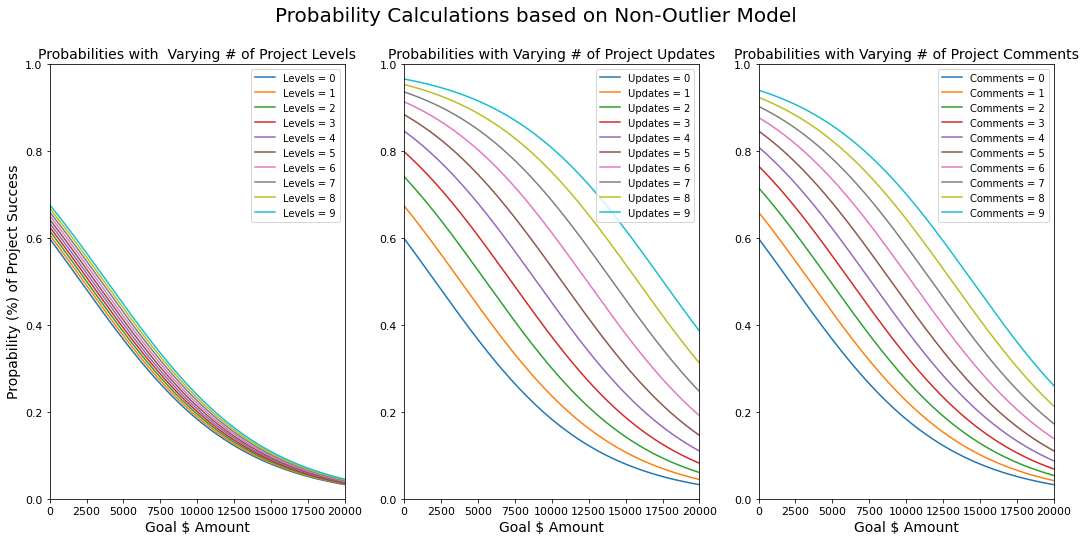

In [119]:
#Currently plotting just how success rate changes given the amount of money you raise
plt.clf()


gta = 20000 # gta = goal test amount
lta = 10 #cta = levels test ammount
uta = 10 #uta = update test ammount
cta = 10 #cta = comment test ammount

x_labels = [5000,10000,15000,20000]

fig = plt.figure(figsize=(18, 8))
fig.suptitle('Probability Calculations based on Non-Outlier Model', fontsize=20)



ax1 = fig.add_subplot(1,3,1)
ax1.set(xlim=[0,gta],ylim=[0,1.0])
ax1.set_xlabel('Goal $ Amount',fontsize=14)
ax1.set_ylabel('Propability (%) of Project Success',fontsize=14)
ax1.set_title("Probabilities with  Varying # of Project Levels", fontsize= 14)



ax2 = fig.add_subplot(1,3,2)
ax2.set(xlim=[0,gta],ylim=[0,1.0])
ax2.set_xlabel('Goal $ Amount',fontsize=14)
ax2.set_title("Probabilities with Varying # of Project Updates", fontsize= 14)


ax3 = fig.add_subplot(1,3,3)
ax3.set(xlim=[0,gta],ylim=[0,1.0])
ax3.set_xlabel('Goal $ Amount',fontsize=14)
ax3.set_title("Probabilities with Varying # of Project Comments", fontsize= 14)



predicted_success = np.zeros(gta)

x_values = list(range(gta))    


i = 0; 
for levels in range(lta):
    for x in range(gta):
        test_case = NoBackers_TestCaseGen(x,levels,0,0,0,'sc_Art')
        predicted_success[x] = no_outlier_logreg.predict_proba(test_case.reshape(1,-1))[0][1]
    y = predicted_success
    ax1.plot(x_values, y, label = 'Levels =' + " " + str(i))
    i += 1


ax1.tick_params(axis='both', which='major', labelsize=11)

# #as we can see, we see an extreme drop off once we get a threshold value
i = 0; 
for updates in range(uta):
    for x in range(gta):
        test_case = NoBackers_TestCaseGen(x,0,updates,0,0,'sc_Art')
        predicted_success[x] = no_outlier_logreg.predict_proba(test_case.reshape(1,-1))[0][1]
    y = predicted_success
    ax2.plot(x_values, y, label = 'Updates =' + " " + str(i))
    i += 1
ax2.tick_params(axis='both', which='major', labelsize=11)


i = 0; 
for comments in range(cta):
    for x in range(gta):
        test_case = NoBackers_TestCaseGen(x,0,0,comments,0,'sc_Art')
        predicted_success[x] = no_outlier_logreg.predict_proba(test_case.reshape(1,-1))[0][1]
    y = predicted_success
    ax3.plot(x_values, y,label = 'Comments =' + " " + str(i))
    i += 1

ax3.tick_params(axis='both', which='major', labelsize=11)

ax1.legend(loc = 'best')
ax2.legend(loc = 'best')
ax3.legend(loc = 'best')

# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# fig.tight_layout()

plt.savefig('C:/Users/ivann/OneDrive/Pictures/' + 'probabilitycalculations.png',bbox_inches='tight')

In [102]:
test_case= NoBackers_TestCaseGen(1,0,0,0,0,'sc_Art')
# print(no_outlier_logreg.predict_proba(test_case.reshape(1,-1))[0][1])


test_case1= NoBackers_TestCaseGen(1,0,0,0,0,'sc_Art')
print(no_outlier_logreg.predict_proba(test_case1.reshape(1,-1))[0][1])

for x in range(10):
    test_case = NoBackers_TestCaseGen(x,0,0,0,0,'sc_Art')
    predicted_success[x] = no_outlier_logreg.predict_proba(test_case.reshape(1,-1))[0][1]
    print(x)
print(predicted_success.reshape(-1,1))


0.5985676439038188
0
1
2
3
4
5
6
7
8
9
[[0.59861322]
 [0.59856764]
 [0.59852207]
 ...
 [0.25981607]
 [0.2597796 ]
 [0.25974313]]


In [103]:
i = 0; 
limit = 10
gta = 5
comment_success = np.zeros(gta)
update_success = np.zeros(gta)

for index in range(limit):
    print(index)
    for x in range(gta):
        comments_tc = NoBackers_TestCaseGen(x,0,0,index,0,'sc_Art')
        comment_success[x] = no_outlier_logreg.predict_proba(comments_tc.reshape(1,-1))[0][1]
        updates_tc = NoBackers_TestCaseGen(x,0,index,0,0,'sc_Art')
        update_success[x] = no_outlier_logreg.predict_proba(updates_tc.reshape(1,-1))[0][1]
    y = comment_success
    y1 = update_success
    # ax2.plot(x_values, y, '-b',label = 'Comments =' + " " + str(i))
    print("Comments")
    print(y)
    print("Updates")
    print(update_success)

0
Comments
[0.59861322 0.59856764 0.59852207 0.59847649 0.59843092]
Updates
[0.59861322 0.59856764 0.59852207 0.59847649 0.59843092]
1
Comments
[0.65934361 0.65930101 0.6592584  0.6592158  0.65917319]
Updates
[0.67369442 0.67365273 0.67361103 0.67356933 0.67352762]
2
Comments
[0.71525617 0.71521754 0.71517891 0.71514027 0.71510163]
Updates
[0.74081225 0.74077583 0.7407394  0.74070298 0.74066655]
3
Comments
[0.76525892 0.76522485 0.76519078 0.7651567  0.76512261]
Updates
[0.79825872 0.79822817 0.79819762 0.79816707 0.79813651]
4
Comments
[0.8088278  0.80879847 0.80876914 0.80873981 0.80871047]
Updates
[0.84562598 0.84560122 0.84557646 0.84555169 0.84552692]
5
Comments
[0.84593811 0.84591339 0.84588867 0.84586394 0.84583921]
Updates
[0.88349495 0.88347543 0.8834559  0.88343637 0.88341684]
6
Comments
[0.8769406  0.87692013 0.87689966 0.87687918 0.87685871]
Updates
[0.91302981 0.91301475 0.91299969 0.91298462 0.91296955]
7
Comments
[0.90242396 0.90240726 0.90239055 0.90237384 0.90235713]
U

In [104]:
print(NoBackers_TestCaseGen(0,0,1,0,0,'sc_Art') - NoBackers_TestCaseGen(0,0,0,0,0,'sc_Art'))
print(NoBackers_TestCaseGen(0,0,0,1,0,'sc_Art') - NoBackers_TestCaseGen(0,0,0,0,0,'sc_Art'))

[[0.         0.         0.15545984 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.01616272 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.    

In [105]:
print(dummy_data.columns)
len(dummy_data.columns) - 5

Index(['goal', 'levels', 'updates', 'comments', 'duration', 'subcategory_Art',
       'subcategory_Art Book', 'subcategory_Board & Card Games',
       'subcategory_Children's Book', 'subcategory_Classical Music',
       'subcategory_Comics', 'subcategory_Conceptual Art',
       'subcategory_Country & Folk', 'subcategory_Crafts', 'subcategory_Dance',
       'subcategory_Design', 'subcategory_Digital Art',
       'subcategory_Documentary', 'subcategory_Electronic Music',
       'subcategory_Fashion', 'subcategory_Fiction',
       'subcategory_Film & Video', 'subcategory_Food', 'subcategory_Games',
       'subcategory_Graphic Design', 'subcategory_Hip-Hop',
       'subcategory_Illustration', 'subcategory_Indie Rock',
       'subcategory_Jazz', 'subcategory_Journalism', 'subcategory_Mixed Media',
       'subcategory_Music', 'subcategory_Narrative Film',
       'subcategory_Nonfiction', 'subcategory_Open Hardware',
       'subcategory_Open Software', 'subcategory_Painting',
       'subcateg

49

In [106]:
print(final_data['subcategory'].sort_values().unique())

['Animation' 'Art' 'Art Book' 'Board & Card Games' "Children's Book"
 'Classical Music' 'Comics' 'Conceptual Art' 'Country & Folk' 'Crafts'
 'Dance' 'Design' 'Digital Art' 'Documentary' 'Electronic Music' 'Fashion'
 'Fiction' 'Film & Video' 'Food' 'Games' 'Graphic Design' 'Hip-Hop'
 'Illustration' 'Indie Rock' 'Jazz' 'Journalism' 'Mixed Media' 'Music'
 'Narrative Film' 'Nonfiction' 'Open Hardware' 'Open Software' 'Painting'
 'Performance Art' 'Periodical' 'Photography' 'Poetry' 'Pop'
 'Product Design' 'Public Art' 'Publishing' 'Rock' 'Sculpture'
 'Short Film' 'Technology' 'Theater' 'Video Games' 'Webseries'
 'World Music']
